<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [14]:
!pip install Keras-applications

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D , UpSampling3D
from tensorflow.keras import optimizers
from keras.datasets import cifar100,cifar10,fashion_mnist
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras import applications
from tensorflow.keras.applications.resnet50 import preprocess_input , decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [16]:
def select_dataset(index=1): #1 for cifar10 , 2 for cifar100 , 3 for fashion mnist
  if(index == 1):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    channel = 3
    num_classes = 10
  if(index == 2):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    num_classes = 100
    channel = 3
  if(index == 3):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape((60000, 28, 28, 1))
    x_test =  x_test.reshape((10000, 28, 28, 1))
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    channel = 1
    return (x_train , y_train , x_test , y_test , num_classes , channel)

  #Pre-process the data
  x_train = preprocess_input(x_train)
  x_test = preprocess_input(x_test)

  datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
  datagen.fit(x_train)
  y_train = np_utils.to_categorical(y_train, num_classes)
  y_test = np_utils.to_categorical(y_test, num_classes)

  return (x_train , y_train , x_test , y_test , num_classes , channel , datagen)

In [17]:
def Inception(num_classes , channel=3):
  if(channel == 3):
    inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else:
    inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

  for layer in inception_model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
  model = Sequential()
  if(channel==1):
    model.add(UpSampling3D((4,4,3)))
  else:
    model.add(UpSampling2D((7,7)))
  model.add(inception_model)
  model.add(GlobalAveragePooling2D())
  '''cifar-10
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(.25))
  #model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(.25))
  #model.add(BatchNormalization())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(.25))
  #model.add(BatchNormalization())
  '''
  '''cifar-100'''
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(.3))
  #model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  #model.add(Dropout(.3))
  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  #model.add(Dropout(.25))
  model.add(BatchNormalization())
  ''''''
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [18]:
index = 1
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = Inception(num_classes,channel)
model_name = 'desktop/Trained_models/inception_cifar10'
model_path = 'desktop/Trained_models/inception_cifar10.h5'

In [6]:
index = 2
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = Inception(num_classes,channel)
model_name = 'desktop/Trained_models/inception_cifar100'
model_path = 'desktop/Trained_models/inception_cifar100.h5'

In [ ]:
index = 3
x_train , y_train , x_test , y_test , num_classes ,channel  = select_dataset(index)
model = Inception(num_classes,channel)
model_name = 'inception_mnist'
model_path = '/content/inception_mnist.h5'

In [ ]:
batch_size = 64
epochs=200
callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True , verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau( factor = 0.9, patience = 5, min_lr = 0.0000001), # cifar-10 - factor-0.8,patience = 3
    #tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 15) # cifar-10 patience - 10
  ]
if(channel == 3):
  history = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks = callbacks)

  model.save(model_path)
else:
  history = model.fit(x_train , y_train , batch_size=batch_size ,steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, validation_data=(x_test, y_test),callbacks=callbacks)
  model.save(model_path)

Epoch 1/200
781/781 [==============================] - ETA: 0s - loss: 3.0807 - accuracy: 0.2570
Epoch 00001: val_accuracy improved from -inf to 0.47560, saving model to desktop/Trained_models/inception_cifar100
INFO:tensorflow:Assets written to: desktop/Trained_models/inception_cifar100/assets
781/781 [==============================] - 145s 186ms/step - loss: 3.0807 - accuracy: 0.2570 - val_loss: 1.9065 - val_accuracy: 0.4756 - lr: 0.0010
Epoch 2/200
781/781 [==============================] - ETA: 0s - loss: 2.0483 - accuracy: 0.4504
Epoch 00002: val_accuracy improved from 0.47560 to 0.58200, saving model to desktop/Trained_models/inception_cifar100
INFO:tensorflow:Assets written to: desktop/Trained_models/inception_cifar100/assets
781/781 [==============================] - 147s 188ms/step - loss: 2.0483 - accuracy: 0.4504 - val_loss: 1.5035 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 3/200
781/781 [==============================] - ETA: 0s - loss: 1.7292 - accuracy: 0.5217
Epoch 00003:

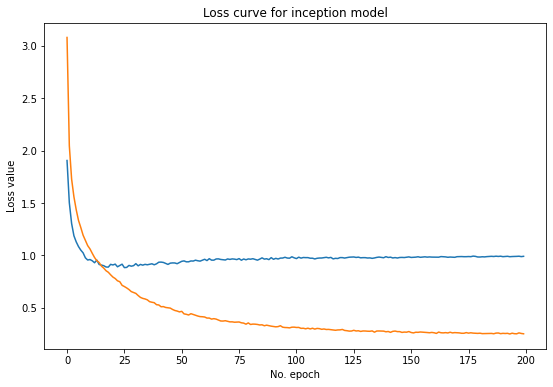

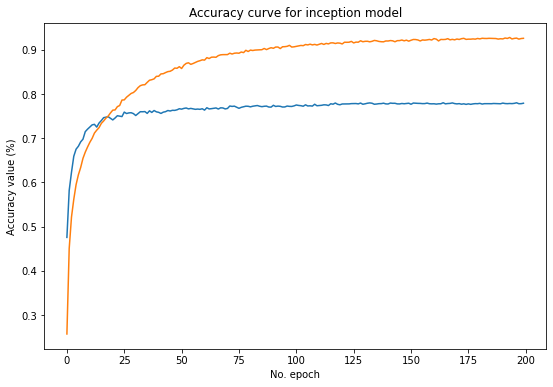

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (9,6))
plt.plot(history.history['val_loss'],label='Test loss')
plt.plot(history.history['loss'],label='Train loss')
plt.title('Loss curve for inception model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (9,6))
plt.plot(history.history['val_accuracy'],label = 'Test accuracy')
plt.plot(history.history['accuracy'],label = 'Train accuracy')
plt.title('Accuracy curve for inception model')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()


In [7]:
import keras,os
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D , Dropout
import numpy as np
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from keras import regularizers
from absl import app, flags

# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Cifar-100

In [8]:


def make_prediction(model , image , true_value):
  true_label_index = -1
  for i in range(len(true_value)):

    if(true_value[i]==1):
      true_label_index = i
      break

  prediction = model.predict(image)[0]
  probability = float('-inf')
  predicted_label_index = -1

  for i in range(len(prediction)):

    if(prediction[i]>probability):
      probability = prediction[i]
      predicted_label_index = i

  if(true_label_index!=predicted_label_index):
    return 1
  return 0

In [9]:
model = keras.models.load_model(model_path)

In [10]:
from keras.preprocessing.image import img_to_array

epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200

result={}
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(model,image,true_value)
    fgsm_sample = fast_gradient_method(model, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(model, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(model , fgsm_sample , true_value)
    pgd_prediction = make_prediction(model , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1


Epsilon value -  0.1

0.1   0
1   1
0.1   1
2   2
0.1   2
3   3
0.1   3
3   3
0.1   4
3   3
0.1   5
4   4
0.1   6
5   4
0.1   7
5   4
0.1   8
6   5
0.1   9
6   5
0.1   10
6   5
0.1   11
7   6
0.1   12
8   6
0.1   13
8   6
0.1   14
8   6
0.1   15
8   6
0.1   16
8   6
0.1   17
8   6
0.1   18
8   6
0.1   19
8   6
0.1   20
8   6
0.1   21
8   6
0.1   22
8   6
0.1   23
9   7
0.1   24
9   7
0.1   25
9   7
0.1   26
9   7
0.1   27
9   7
0.1   28
9   7
0.1   29
10   8
0.1   30
10   8
0.1   31
10   8
0.1   32
10   8
0.1   33
11   9
0.1   34
12   10
0.1   35
12   10
0.1   36
12   10
0.1   37
12   10
0.1   38
12   10
0.1   39
12   10
0.1   40
13   10
0.1   41
14   11
0.1   42
14   11
0.1   43
15   12
0.1   44
15   12
0.1   45
15   12
0.1   46
15   12
0.1   47
15   12
0.1   48
16   13
0.1   49
16   13
0.1   50
16   13
0.1   51
17   14
0.1   52
17   14
0.1   53
17   14
0.1   54
17   14
0.1   55
18   15
0.1   56
18   15
0.1   57
18   15
0.1   58
18   15
0.1   59
18   15
0.1   60
18   15
0.1   61
18   

In [11]:
for key in result.keys():
  print(key,' ',result[key])

0.1   (60, 68)
0.2   (84, 107)
0.30000000000000004   (97, 130)
0.4   (105, 143)
0.5   (111, 143)
0.6   (122, 143)
0.7   (130, 143)
0.7999999999999999   (135, 143)


cifar-10

In [19]:
model = keras.models.load_model(model_path)
epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(model,image,true_value)
    fgsm_sample = fast_gradient_method(model, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(model, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(model , fgsm_sample , true_value)
    pgd_prediction = make_prediction(model , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1

Epsilon value -  0.1

0.1   0
0   0
0.1   1
0   0
0.1   2
0   0
0.1   3
0   0
0.1   4
0   0
0.1   5
0   0
0.1   6
0   0
0.1   7
0   0
0.1   8
0   0
0.1   9
1   0
0.1   10
2   1
0.1   11
2   1
0.1   12
3   2
0.1   13
3   2
0.1   14
3   2
0.1   15
4   3
0.1   16
4   3
0.1   17
4   3
0.1   18
4   3
0.1   19
4   3
0.1   20
5   4
0.1   21
5   4
0.1   22
5   4
0.1   23
5   4
0.1   24
6   5
0.1   25
7   6
0.1   26
8   6
0.1   27
8   6
0.1   28
8   6
0.1   29
8   6
0.1   30
8   6
0.1   31
8   6
0.1   32
8   6
0.1   33
8   6
0.1   34
8   6
0.1   35
8   6
0.1   36
8   6
0.1   37
9   7
0.1   38
9   7
0.1   39
9   7
0.1   40
10   8
0.1   41
10   8
0.1   42
10   8
0.1   43
10   8
0.1   44
10   8
0.1   45
10   8
0.1   46
11   9
0.1   47
11   9
0.1   48
11   9
0.1   49
11   9
0.1   50
11   9
0.1   51
11   9
0.1   52
11   9
0.1   53
12   10
0.1   54
12   10
0.1   55
12   10
0.1   56
12   10
0.1   57
13   11
0.1   58
14   12
0.1   59
15   13
0.1   60
15   13
0.1   61
15   13
0.1   62
15   13
0.1   63
1

In [22]:
for key in result.keys():
  print(key,' ',result[key])

0.1   (33, 44)
0.2   (49, 78)
0.30000000000000004   (63, 107)
0.4   (72, 115)
0.5   (80, 115)
0.6   (90, 115)
0.7   (96, 115)
0.7999999999999999   (102, 115)
